<a href="https://colab.research.google.com/github/Caio-Oliveira98/ML/blob/main/Global_Solution_Redes_Neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Projeto: Rede Neural Convolucional para Reconhecimento de Imagens de Enchentes e Pessoas em Risco

##1. Objetivo do Projeto
#Diante das recentes inundações no Rio Grande do Sul e seus impactos devastadores, este projeto visa desenvolver uma Rede Neural Convolucional (CNN) usando MobileNet para integrar um sistema de monitoramento inteligente. Isso permitirá o reconhecimento automático de pessoas em perigo durante enchentes, acionando serviços de emergência como bombeiros e defesa civil com mais agilidade, potencialmente salvando vidas.

##2.Coleta de Imagens
#Compilamos um banco de dados de imagens de enchentes urbanas e pessoas em risco, especialmente incidentes recentes no Rio Grande do Sul.

##3. Importaçao das Bibliotecas necessárias

In [1]:
# Importação das bibliotecas necessárias para processamento e modelagem
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

##4.Processamento e Separaçao de Dados

In [2]:
#Criando os diretórios

def create_directories(base_dir):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

create_directories('/content/dataset/train/Enchentes')
create_directories('/content/dataset/val/Enchentes')
create_directories('/content/dataset/train/Pessoas')
create_directories('/content/dataset/val/Pessoas')

def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []  # Lista para armazenar os arquivos de imagem
    for filename in os.listdir(SOURCE):  # Itera sobre todos os arquivos no diretório SOURCE
        file = os.path.join(SOURCE, filename)  # Cria o caminho completo do arquivo
        if os.path.isfile(file) and os.path.getsize(file) > 0:  # Verifica se é um arquivo válido
            files.append(filename)  # Adiciona o arquivo à lista

    train_set, validation_set = train_test_split(files, test_size=1-SPLIT_SIZE, random_state=42)  # Divide os arquivos entre treino e validação

    # Copia os arquivos de treinamento para o diretório de treinamento
    for filename in train_set:
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(TRAINING, filename))

    # Copia os arquivos de validação para o diretório de validação
    for filename in validation_set:
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(VALIDATION, filename))

# Divide e organiza os dados das imagens de enchentes e pessoas
split_data('/content/Imagens_Enchentes/', '/content/dataset/train/Enchentes/', '/content/dataset/val/Enchentes/', SPLIT_SIZE=0.8)
split_data('/content/Imagens_Pessoas/', '/content/dataset/train/Pessoas/', '/content/dataset/val/Pessoas/', SPLIT_SIZE=0.8)

##5. Pré processamento de Imagens


In [3]:
# Configura transformações para aumento de dados (data augmentation) no conjunto de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza os valores dos pixels para o intervalo [0, 1]
    rotation_range=20,  # Rotação aleatória das imagens
    width_shift_range=0.2,  # Deslocamento horizontal aleatório
    height_shift_range=0.2,  # Deslocamento vertical aleatório
    zoom_range=0.2,  # Zoom aleatório
    horizontal_flip=True,  # Inversão horizontal
    fill_mode='nearest'  # Como preencher novos pixels criados após transformações
)

# Apenas normalização para o conjunto de validação
validation_datagen = ImageDataGenerator(rescale=1./255)

# Cria o gerador de dados para o conjunto de treinamento
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train/',  # Diretório de imagens de treinamento
    target_size=(224, 224),  # Redimensiona as imagens
    batch_size=32,  # Tamanho do lote
    class_mode='binary'  # Tipo de classificação (binária)
)

# Cria o gerador de dados para o conjunto de validação
validation_generator = validation_datagen.flow_from_directory(
    '/content/dataset/val/',  # Diretório de imagens de validação
    target_size=(224, 224),  # Redimensiona as imagens
    batch_size=32,  # Tamanho do lote
    class_mode='binary'  # Tipo de classificação (binária)
)

Found 21 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


##6. Construçao do Modelo com MobileNet

In [4]:
# Configuração do modelo base com MobileNet pré-treinada
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Criação do modelo sequencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,491,521 (13.32 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

##7. Treinamento e Avaliaçao

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5238 - loss: 1.0750 - val_accuracy: 0.4286 - val_loss: 0.8889 - learning_rate: 1.0000e-04
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5714 - loss: 0.8234 - val_accuracy: 0.5714 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6190 - loss: 0.6511 - val_accuracy: 0.5714 - val_loss: 0.6340 - learning_rate: 1.0000e-04
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3333 - loss: 1.0075 - val_accuracy: 0.8571 - val_loss: 0.5573 - learning_rate: 1.0000e-04
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.4286 - loss: 0.9539 - val_accuracy: 0.8571 - val_loss: 0.5005 - learning_rate: 1.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.6190 - loss: 0.5936 - val_accuracy: 0.8571 - val_loss: 0.4597 - learning_rate: 1.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.4762 - loss: 0.7

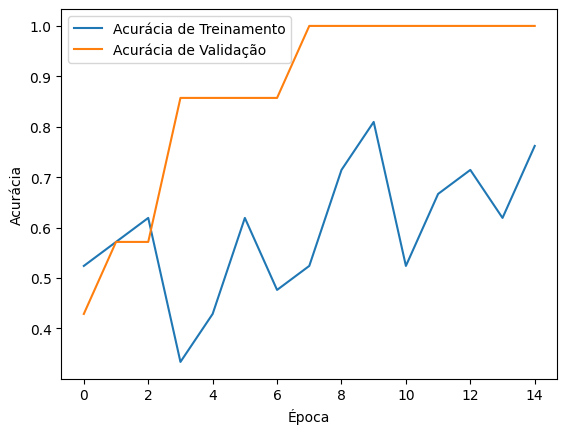

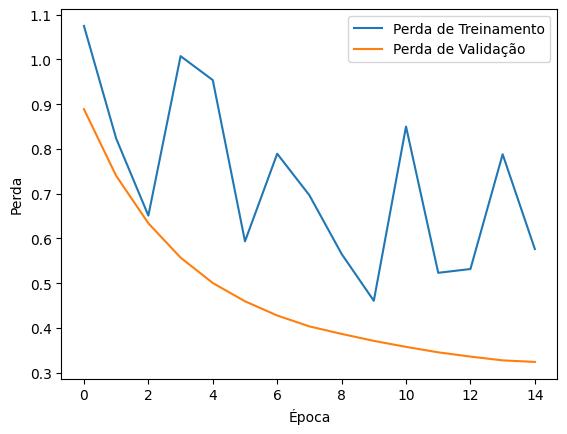

In [5]:
# Adicionando callbacks para early stopping e ajuste da taxa de aprendizado
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

# Visualização dos resultados
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

##8. Análise do Modelo

Precisão de Treinamento vs. Validação:

Treinamento: A precisão do treinamento mostrou flutuações significativas, o que pode indicar que o modelo está aprendendo padrões complexos ou está experimentando sobreajuste.

Validação: A precisão de validação aumentou de forma mais consistente, sugerindo que o modelo está aprendendo a generalizar para dados não vistos.

Perda de Treinamento vs. Validação:

Treinamento: A perda de treinamento diminuiu acentuadamente, o que era esperado, mas as flutuações indicam que pode haver um ajuste excessivo.

Validação: A perda de validação reduziu de forma mais moderada, o que sugere que o modelo tem um bom potencial de generalização, ainda que a diferença entre as perdas de treinamento e validação possa indicar algum grau de overfitting.

##9. Demonstraçao Prática do Modelo


In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

img_path = '/content/Imagem_Teste/teste final.jpeg'  # Caminho da imagem para teste

# Carrega a imagem
img = image.load_img(img_path, target_size=(224, 224))

# Converte a imagem para um array NumPy
img_array = image.img_to_array(img)

# Adiciona uma dimensão extra para se adequar ao formato de entrada do modelo
img_array_expanded = np.expand_dims(img_array, axis=0)

# Pré-processa a imagem usando a função da MobileNet
img_preprocessed = preprocess_input(img_array_expanded)

# Faz a previsão usando o modelo treinado
prediction = model.predict(img_preprocessed)

# Interpreta e exibe o resultado da previsão
# Supondo que o modelo tenha duas classes
# Obtemos o índice da classe com maior probabilidade
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Mapeamento dos índices para as classes
class_labels = ['Apenas alagamento', 'Pessoa em risco']

# Exibir o resultado
print(f"Previsão: {class_labels[predicted_class_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Previsão: Pessoa em risco


In [19]:
print(train_generator.class_indices)

{'Enchentes': 0, 'Pessoas': 1}


##10. Conclusao Final


O modelo foi capaz de interpretar que uma pessoa estava em perigo e classificou corretamente uma imagem que nao estava presente na base de dados original.